## Imbalanced_Classes

### Steps to take
<font color='grey'>step 1: Import all the necessary python packages</font><br>
<font color='grey'>step 2: Obtain and clean data</font> <br>
<font color='grey'>step 3: Data Exploration</font> <br>
<font color='grey'>step 4: Modify data for Machine Learning</font><br>
<font color='grey'>step 5: Get dummies</font><br>
<font color='grey'>step 6: Split data into train and test</font><br> 
step 6: Standard scaling<br>
step 7: Dealing with Imbalanced Data:
- Logistic Regression "class_weight" parameter
- SMOTE (oversampling)
- Undersampling

step 8: logistic regression<br>
<font color='grey'>step 9: parameter tuning</font><br>
<font color='grey'>step 10: provide actionable recommendations</font><br>



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', size=14)
import seaborn as sns 
# sns.set(style='white')
# sns.set(style='whitegrid', color_codes=True)

#Machine Learning Modules
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, auc#, classifiction_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve
from yellowbrick.classifier import ConfusionMatrix
# ignore warnings
import warnings; warnings.simplefilter('ignore')

# autoreload 
%load_ext autoreload
%autoreload 2

#logistic regression script
import logistic_regression

In [2]:
## Load Train data from data/Train
Train = pd.read_csv('data/Train.csv',)
X_train = Train.drop('target', axis = 1)
y_train = Train['target']
# X_train.columns

## Step 6: Standard Scaling

In [3]:
# StandardScaler
scaler = StandardScaler().fit(X_train)
columns = X_train.columns

scaled_train = scaler.transform(X_train)
X_train_scaled = pd.DataFrame(scaled_train, columns=columns)

print(X_train_scaled.shape)
X_train_scaled.head()

(32940, 45)


,age,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,...,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,-0.293135,-0.564625,-0.19645,1.679762,-0.539824,-0.191649,-0.165773,-0.273916,-0.209108,-0.190026,...,-0.709185,-0.333783,-0.129585,-0.119922,-0.511124,-0.515608,-0.494967,-0.494729,-2.511053,-0.186655
1,-0.676809,-0.204519,-0.19645,-0.350523,-0.539824,-0.191649,-0.165773,-0.273916,-0.209108,-0.190026,...,-0.709185,-0.333783,-0.129585,-0.119922,-0.511124,-0.515608,2.020338,-0.494729,0.398239,-0.186655
2,-0.676809,-0.564625,-0.19645,-0.350523,-0.539824,-0.191649,-0.165773,-0.273916,-0.209108,-0.190026,...,-0.709185,-0.333783,-0.129585,-0.119922,-0.511124,-0.515608,2.020338,-0.494729,0.398239,-0.186655
3,-0.197216,0.155587,-0.19645,-0.350523,-0.539824,-0.191649,-0.165773,-0.273916,-0.209108,-0.190026,...,-0.709185,-0.333783,-0.129585,-0.119922,1.956473,-0.515608,-0.494967,-0.494729,0.398239,-0.186655
4,0.090540,-0.564625,-0.19645,-0.350523,-0.539824,-0.191649,-0.165773,-0.273916,-0.209108,-0.190026,...,-0.709185,-0.333783,-0.129585,-0.119922,1.956473,-0.515608,-0.494967,-0.494729,0.398239,-0.186655


## Step 7.0: No treatment

In [4]:
#without class weight 
logreg_baseline = LogisticRegression(C = 1e9, solver='newton-cg')
logreg_baseline.fit(X_train_scaled, y_train)
y_hat_vanilla_baseline = logreg_baseline.predict(X_train_scaled)

In [5]:
print(f"score = {np.round(logreg_baseline.score(scaled_train, y_train), 3)}")
logistic_regression.print_metrics(y_train, y_hat_vanilla_baseline)

score = 0.898
precision = 0.661
recall = 0.189
accuracy = 0.661
f1 score = 0.294


## Step 7.1: No treatment, using class_weight parameter in sklearn LogisticRegression

In [6]:
logreg_base_classweight = LogisticRegression(C = 1e9, class_weight='balanced', solver='newton-cg')
logreg_base_classweight.fit(X_train_scaled, y_train)
y_hat_base_classweight = logreg_base_classweight.predict(X_train_scaled)

print(f"score = {np.round(logreg_base_classweight.score(X_train_scaled, y_train), 3)}")
logistic_regression.print_metrics(y_train, y_hat_base_classweight)

score = 0.803
precision = 0.302
recall = 0.572
accuracy = 0.302
f1 score = 0.395


Interesting - The model score decreased.<br>
Our recall and f1 score look better, but we should try other methods. <br>

Next we will try resampling the data using two different methods:
    - Oversampling with synthetic data (SMOTE)
    - Undersampling

## Step 7.2: Using SMOTE 
Here we try to up-sample the subscription class (minority) using the SMOTE algorithm(Synthetic Minority Oversampling Techique).<br>
It works by creating synthetic samples from the minor class (no-subscription) instead of creating copies.
Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observations.


In [9]:
# from imblearn.over_sampling import SMOTE 
from imblearn.over_sampling import SMOTE
# columns = scaled_train.columns
os = SMOTE(random_state=19)
os_data_X, os_data_y = os.fit_sample(X_train_scaled, y_train)
os_data_X = pd.DataFrame(data=os_data_X, columns=columns)
os_y=os_data_y.reshape(-1, 1)

# check numbers
print('Length of oversampled data is', len(os_data_X))
print('Number of no subscription in oversampled data', np.sum(os_data_y==0))
print('Number of subscription', np.sum(os_data_y==1))
print('Proportion of no subscription data in oversampled data is', np.sum(os_data_y==0)/len(os_data_y))
print('Proportion of subscription data in oversampled data is', np.sum(os_data_y==1)/len(os_data_y))

Length of oversampled data is 58458
Number of no subscription in oversampled data 29229
Number of subscription 29229
Proportion of no subscription data in oversampled data is 0.5
Proportion of subscription data in oversampled data is 0.5


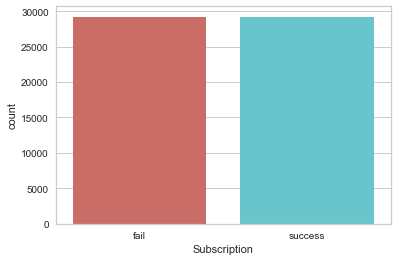

In [10]:
# print(bank_clean['target'].value_counts(normalize=True))
c=sns.countplot(x=os_data_y, palette='hls')#, data=bank_clean, palette='hls', )
plt.xlabel('Subscription')
c.set_xticklabels(['fail','success']);

plt.savefig('img/count_plot_SMOTE')

In [11]:
# Perform vanilla logistic regression
logreg_base_SMOTE = LogisticRegression(C = 1e9, solver='newton-cg')
logreg_base_SMOTE.fit(os_data_X, os_data_y)
y_hat_base_SMOTE = logreg_base_SMOTE.predict(os_data_X)

print(f"score = {np.round(logreg_base_SMOTE.score(os_data_X, os_data_y),3)}")
logistic_regression.print_metrics(os_data_y, y_hat_base_SMOTE)

score = 0.708
precision = 0.754
recall = 0.617
accuracy = 0.754
f1 score = 0.679


The model score decreased again from 80% to 71%.<br>
However, the SMOTE method seems to increase all other metric scores. 

## Step 7.3: Using undersampling technique
This technique undersamples the majority class randomly

In [26]:
from sklearn.utils import resample

# concatenate our training data back together
X = pd.concat([X_train_scaled, y_train], axis=1)
X.head()
# separate minority and majority classes
success = X[X.target==1]
failure = X[X.target==0]
print(f"success original count: {len(success)}")
print(f"failure original count: {len(failure)}")

# downsample majority
failure_downsampled = resample(failure,
                               replace = False, # sample without replacement
                               n_samples = len(success), # match minority n
                               random_state = 19) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([failure_downsampled, success])

# checking counts
downsampled.target.value_counts()

success original count: 3711
failure original count: 29229


1    3711
0    3711
Name: target, dtype: int64

In [27]:
# Trying vanilla logistic regression again with the balanced dataset
y_train_undersample = downsampled['target']
X_train_undersample = downsampled.drop('target', axis=1)

downsampled_lr = LogisticRegression(C = 1e9, solver='newton-cg', max_iter=1000)
downsampled_lr.fit(X_train_undersample, y_train_undersample)

downsampled_pred = downsampled_lr.predict(X_train_undersample)

print(f"score = {np.round(downsampled_lr.score(X_train_undersample, y_train_undersample), 3)}")
logistic_regression.print_metrics(y_train_undersample, downsampled_pred)

score = 0.701
precision = 0.767
recall = 0.578
accuracy = 0.767
f1 score = 0.659


The model score is slightly lower compared to SMOTE. <br>
The metric scores are about the same compared to SMOTE but SMOTE looks slightly better

##  Step 8: Recursive Feature Elimination (RFE)

In [28]:
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='lbfgs')

rfe = RFE(logreg, 10)
rfe = rfe.fit(os_data_X, os_data_y)
col_list = zip(os_data_X.columns, rfe.support_)
X_new_cols = [x[0] for x in col_list if x[1]==True]
# print(X_new_cols)
X_new = os_data_X[X_new_cols]
print(X_new.shape)
X_new.head()

(58458, 10)


,campaign,pdays,job_retired,default_unknown,contact_telephone,month_aug,month_jul,month_may,month_nov,poutcome_nonexistent
0,-0.564625,-0.19645,-0.209108,-0.515042,-0.757855,-0.420234,-0.459331,-0.709185,-0.333783,-2.511053
1,-0.204519,-0.19645,-0.209108,-0.515042,-0.757855,-0.420234,2.177080,-0.709185,-0.333783,0.398239
2,-0.564625,-0.19645,-0.209108,-0.515042,1.319514,-0.420234,2.177080,-0.709185,-0.333783,0.398239
3,0.155587,-0.19645,-0.209108,-0.515042,1.319514,-0.420234,-0.459331,-0.709185,-0.333783,0.398239
4,-0.564625,-0.19645,-0.209108,-0.515042,-0.757855,-0.420234,2.177080,-0.709185,-0.333783,0.398239


In [29]:
#Try applying new feature list into vanilla regression
rfe_lr = LogisticRegression(C = 1e9, solver='newton-cg', max_iter=1000)
rfe_lr.fit(X_new, os_data_y)
rfe_pred = rfe_lr.predict(X_new)

print(f"score = {np.round(rfe_lr.score(X_new, os_data_y), 3)}")
rfe_lst = logistic_regression.print_metrics(os_data_y, rfe_pred)

score = 0.694
precision = 0.745
recall = 0.591
accuracy = 0.745
f1 score = 0.659


**Feature elimination does not seem to increase our scores. And in order to keep the interpretability of our results, we will choose SMOTE as a way to address data imbalance.** 

## Step 9: Regularization and kFold Cross-Validation -- Using SMOTE'd data


In [31]:
# Vanilla 
vanilla_result, vanilla_lr, vanilla_cv = logistic_regression.cross_validation(n=10, shuffle=True,
                                                                             lr='vanilla',
                                                                             X_train=os_data_X,
                                                                             y_train=os_data_y,C=10e9)
# Ridge (l2)
l2_result, l2_reg, cv_l2 = logistic_regression.cross_validation(n=10, shuffle=True,
                                                                lr='l2',
                                                                X_train=os_data_X,
                                                                y_train=os_data_y, C=1)
# Lasso (l1)
l1_result, l1_reg, cv_l1 = logistic_regression.cross_validation(n=10, shuffle=True,
                                                                lr='l1',
                                                                X_train=os_data_X,
                                                                y_train=os_data_y,C=1)
# calculate the mean
print('Means:')
print('Vanilla regularization: ', vanilla_result.mean(axis=0))
print('l1 regularization: ', l1_result.mean(axis=0))
print('l2 regularixation: ', l2_result.mean(axis=0))

# calculate the std
print('------------------------------------')
print("Standard deviation")
print('Vanila regularization: ', vanilla_result.std(axis=0))
print('l1 regularization: ', l1_result.std(axis=0))
print('l2 regularization: ', l2_result.std(axis=0))

Means:
Vanilla regularization:  [0.70826158 0.70737965]
l1 regularization:  [0.70825968 0.7074994 ]
l2 regularixation:  [0.70824828 0.70741386]
------------------------------------
Standard deviation
Vanila regularization:  [0.00044485 0.00297381]
l1 regularization:  [0.00045885 0.00288845]
l2 regularization:  [0.0004411  0.00295954]


#### L1 and L2 Regularizations don't show any difference in model score. We will keep both and see whether varying C (penalization) values will help us choose

In [32]:
l1_mean_lst = []
l1_std_lst = []
for i in [1e9, 1e2, 1, 1e-2, 1e-9]:
    l1_result, l1_reg, cv_l1 = logistic_regression.cross_validation(n=5, shuffle=True, lr='l1',
                                                                    X_train=os_data_X,
                                                                    y_train=os_data_y,
                                                                    C = i)
    l1_mean_lst.append(l1_result.mean(axis=0))
    l1_std_lst.append(l1_result.std(axis=0))
#     print(f"C={i} result: {l1_result}")

In [36]:
y_l1_std_plot = [x[0] for x in l1_std_lst]
y_l1_mean_plot = [x[0] for x in l1_mean_lst]
print(y_l1_std_plot)
print(y_l1_mean_plot)

[0.0006280413246646159, 0.00063168041926533, 0.0006791418857973408, 0.0010231119879172922, 0.0]
[0.7081408829635186, 0.7081451593918457, 0.7081665418992534, 0.7081152271368494, 0.5]


In [34]:
l2_mean_lst = []
l2_std_lst = []
for i in [1e9, 1e2, 1, 1e-2, 1e-9]:
    l2_result, l2_reg, cv_l2 = logistic_regression.cross_validation(n=5, shuffle=True, lr='l2',
                                                                    X_train=os_data_X,
                                                                    y_train=os_data_y,
                                                                    C = i)
    l2_mean_lst.append(l2_result.mean(axis=0))
    l2_std_lst.append(l2_result.std(axis=0))
#     print(f"C={i} result: {l2_result}") #, l1_reg, cv_l1 )

In [35]:
y_l2_std_plot = [x[0] for x in l2_std_lst]
y_l2_mean_plot = [x[0] for x in l2_mean_lst]
print(y_l2_std_plot)
print(y_l2_mean_plot)

[0.0006280413246646159, 0.0006280413246646159, 0.0006405102708922318, 0.000628168109968405, 0.0007806922282804006]
[0.7081408829635186, 0.7081408829635186, 0.7081237767015518, 0.7078971205136313, 0.655727182358872]


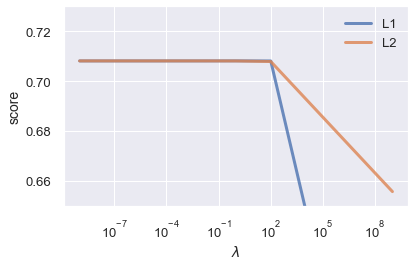

In [79]:
C = [1/1e9, 1/1e2, 1/1, 1/1e-2, 1/1e-9]

sns.set(font_scale=1.2)
sns.lineplot(x=C, y=y_l1_mean_plot, lw=3, alpha=.8, label='L1')
sns.lineplot(x=C, y=y_l2_mean_plot, lw=3, alpha=.8, label='L2')
plt.xscale("log")
plt.ylim(.65,.73)
plt.xlabel('$\lambda$',fontsize=14)
plt.ylabel('score',fontsize=14)
plt.tight_layout()
plt.legend()

plt.savefig('img/Cscore_L1_L2');

From the graph above we concluded that L1 and L2 Regularization give us the same scores for $\lambda$ lower than 100. 
Moving forward we choose:
- **L2** (because we do not need sparse regularization)
- With **C-value = 100** (middle point of our testing range)

## Step 10: L2 Regularization with C=100 Using SMOTE'd data

In [90]:
# from sklearn.linear_model import LogisticRegression
l2_reg = LogisticRegression(C=100, solver='newton-cg', max_iter=1000)
l2_reg.fit(X=os_data_X, y=os_data_y)
l2_reg_pred = l2_reg.predict(os_data_X)
from sklearn.metrics import confusion_matrix
conf_matrix = pd.DataFrame(confusion_matrix(y_true=os_data_y,
                                            y_pred=l2_reg_pred),
                           index= ['actual 0', 'actual 1'],
                           columns= ['predicted 0', 'predicted 1']) 
logistic_regression.print_metrics(y_train=os_data_y, y_hat=l2_reg_pred)
conf_matrix

precision = 0.754
recall = 0.617
accuracy = 0.754
f1 score = 0.679


,predicted 0,predicted 1
actual 0,23358,5871
actual 1,11188,18041


precision = 0.754
recall = 0.617
accuracy = 0.754
f1 score = 0.679
None


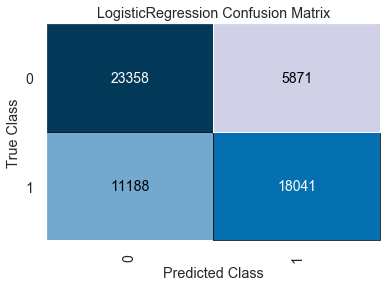

In [113]:
print(logistic_regression.print_metrics(y_train=os_data_y, y_hat=l2_reg_pred))
cm = ConfusionMatrix(l2_reg, cmap='PuBu', fontsize=14, is_fitted=True)
cm.fit(os_data_X, os_data_y)
cm.score(os_data_X, os_data_y)
cm.show();

Average precision-recall score: 0.66


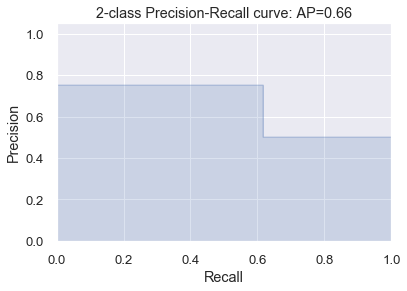

In [84]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from inspect import signature

l2_reg.fit(X=os_data_X, y=os_data_y)
y_score = l2_reg.predict(os_data_X)

precision, recall, _ = precision_recall_curve(os_data_y, y_score)

from sklearn.metrics import average_precision_score
average_precision = average_precision_score(os_data_y, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision));

## Step 11: Finding Optimum Threshold, Maximizing F1 Score

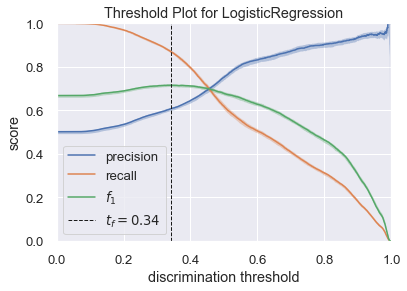

In [89]:
from yellowbrick.classifier import DiscriminationThreshold

# Load a binary classification dataset
X, y = os_data_X, os_data_y

# Instantiate the classification model and visualizer
l2_reg = LogisticRegression(C=100, solver='newton-cg', max_iter=1000)
visualizer = DiscriminationThreshold(l2_reg, exclude='queue_rate', is_fitted=True)

visualizer.fit(X, y)        # Fit the data to the visualizer
        
plt.savefig('img/Threshold')
visualizer.show();          # Finalize and render the figure

In [97]:
l2_reg = LogisticRegression(C=100, solver='newton-cg', max_iter=1000,penalty='l2')
l2_reg.fit(X=os_data_X, y=os_data_y)
# l2_reg_pred = l2_reg.predict(os_data_X)
y_hat_thres = 1*(l2_reg.predict_proba(os_data_X)[:,1] >= 0.34)
from sklearn.metrics import confusion_matrix
conf_matrix = pd.DataFrame(confusion_matrix(y_true=os_data_y,
                                            y_pred=y_hat_thres),
                           index= ['actual 0', 'actual 1'],
                           columns= ['predicted 0', 'predicted 1']) 
logistic_regression.print_metrics(y_train=os_data_y, y_hat=y_hat_thres)
conf_matrix

precision = 0.607
recall = 0.873
accuracy = 0.607
f1 score = 0.716


,predicted 0,predicted 1
actual 0,12735,16494
actual 1,3711,25518


## Step 12: Test Final Model With Test Data

In [98]:
## Load Test data from data/Test
Test = pd.read_csv('data/Test.csv',)
X_test = Test.drop('target', axis = 1)
y_test = Test['target']
len(y_test)

8236

In [99]:
#Scale Test Data 

scaled_test = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(scaled_test, columns=columns)


precision = 0.265
recall = 0.596
accuracy = 0.265
f1 score = 0.367
None


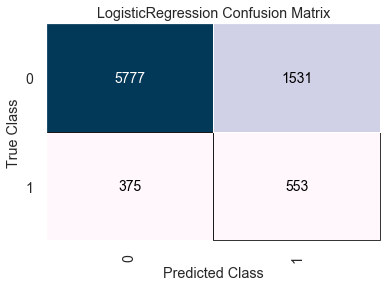

In [112]:
y_hat = l2_reg.predict(X_test_scaled)

print(logistic_regression.print_metrics(y_train=y_test, y_hat=y_hat))

cm = ConfusionMatrix(l2_reg, cmap='PuBu', fontsize=14,is_fitted=True)
cm.fit(os_data_X, os_data_y)
cm.score(X_test_scaled, y_test)
cm.show();

With Optimum Threshold

In [109]:
y_hat_thres = 1*(l2_reg.predict_proba(X_test_scaled)[:,1] >= 0.34)

conf_matrix = pd.DataFrame(confusion_matrix(y_true=y_test,
                                            y_pred=y_hat_thres),
                           index= ['actual 0', 'actual 1'],
                           columns= ['predicted 0', 'predicted 1']) 
logistic_regression.print_metrics(y_train=y_test, y_hat=y_hat_thres)
conf_matrix





precision = 0.158
recall = 0.843
accuracy = 0.158
f1 score = 0.266


,predicted 0,predicted 1
actual 0,3138,4170
actual 1,146,782


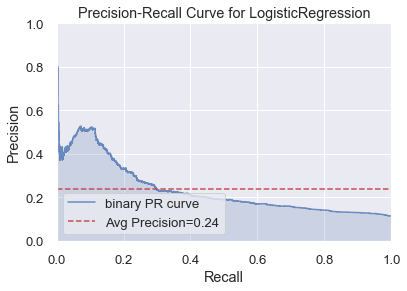

In [111]:
from yellowbrick.classifier import PrecisionRecallCurve

# Create the visualizer, fit, score, and show it
viz = PrecisionRecallCurve(l2_reg)
viz.fit(os_data_X, os_data_y)
viz.score(X_test, y_test)
viz.show();


Average precision-recall score: 0.13


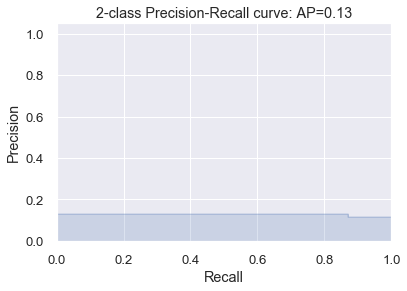

In [114]:
y_score = l2_reg.predict(X_test)

precision, recall, _ = precision_recall_curve(y_test, y_score)
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision));